# Comparison of different available functions

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
# from zernipax import set_device
# set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(precision=3, threshold= sys.maxsize, suppress=False)
import mpmath
import matplotlib
import matplotlib.pyplot as plt
from zernipax.zernike import *
from zernipax.basis import ZernikePolynomial, FourierZernikeBasis
from zernipax.plotting import plot_basis

using JAX backend, jax version=0.4.28, jaxlib version=0.4.28, dtype=float64
Using device: CPU, with 7.33 GB available memory


In [4]:
res = 50
basis = ZernikePolynomial(L=res, M=res, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

In [5]:
dr = 0
%timeit zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

1.13 ms ± 78.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.23 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.41 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print("zernike_radial_poly, 0th derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=0, exact=False)
print("zernike_radial_poly, 1st derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=1, exact=False)
print("zernike_radial_poly, 2nd derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=2, exact=False)
print("zernike_radial_poly, 3rd derivative")
%timeit _ = zernike_radial_poly(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr=3, exact=False)

In [6]:
# Exact computation
mpmath.mp.dps = 100
c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)
zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
zt1 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 1, exact=True)]).T
zt2 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 2, exact=True)]).T
zt3 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 3, exact=True)]).T
# Newest function
zr0 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 0)
zr1 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 1)
zr2 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 2)
zr3 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 3)
# Old Desc version
zd0 = zernike_radial_old_desc(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 0
)
zd1 = zernike_radial_old_desc(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 1
)
zd2 = zernike_radial_old_desc(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 2
)
zd3 = zernike_radial_old_desc(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 3
)

# Exact computation
mpmath.mp.dps = 10
# Polynomial computation
zp0 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=0, exact=False
)
zp1 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=1, exact=False
)
zp2 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=2, exact=False
)
zp3 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=3, exact=False
)

In [7]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Custom cmap", cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.logspace(-16, 0, 17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

Text(0.5, 1.0, '$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$')

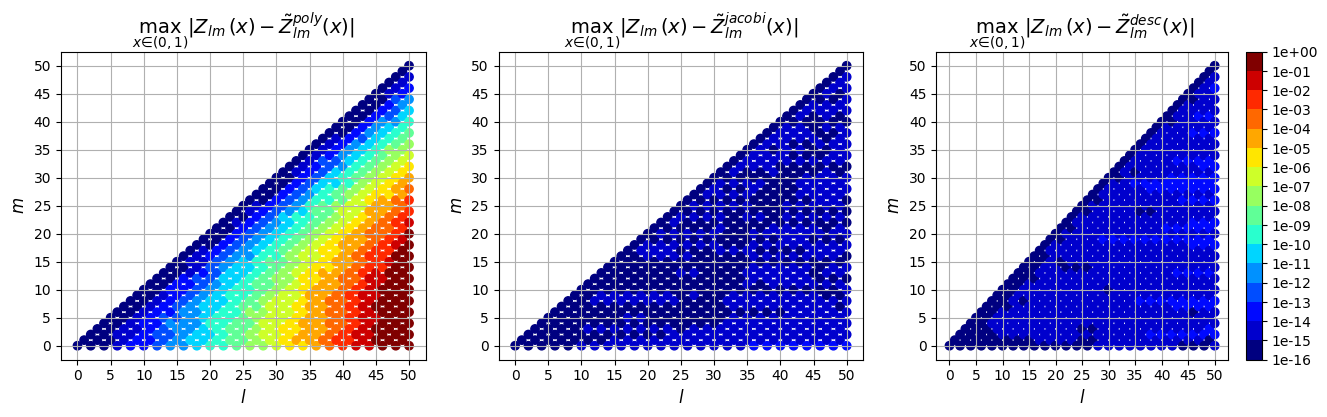

In [8]:
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(16, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zd0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, res+1, 5))
ax[0].set_yticks(np.arange(0, res+1, 5))
ax[1].set_xticks(np.arange(0, res+1, 5))
ax[1].set_yticks(np.arange(0, res+1, 5))
ax[2].set_xticks(np.arange(0, res+1, 5))
ax[2].set_yticks(np.arange(0, res+1, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$", fontsize=14
)
ax[2].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$", fontsize=14
)

Text(0.5, 1.0, '$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$')

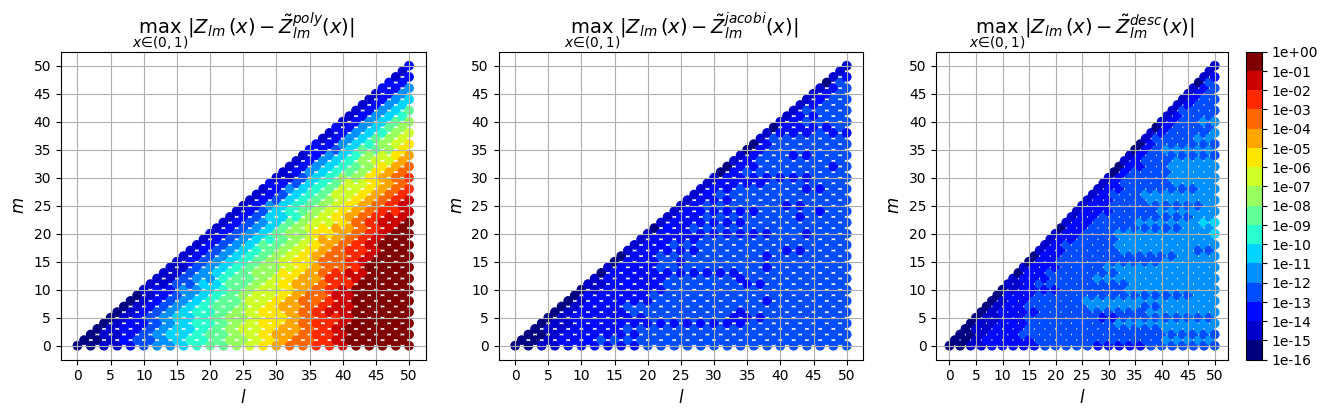

In [9]:
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(16, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp1 - zt1), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr1 - zt1), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zd1 - zt1), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, res+1, 5))
ax[0].set_yticks(np.arange(0, res+1, 5))
ax[1].set_xticks(np.arange(0, res+1, 5))
ax[1].set_yticks(np.arange(0, res+1, 5))
ax[2].set_xticks(np.arange(0, res+1, 5))
ax[2].set_yticks(np.arange(0, res+1, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$", fontsize=14
)
ax[2].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$", fontsize=14
)

Text(0.5, 1.0, '$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$')

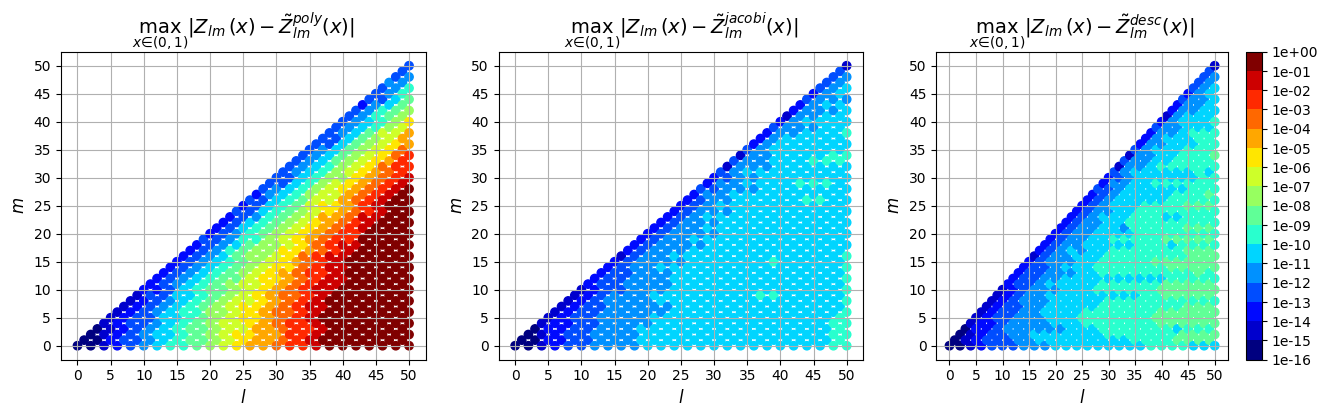

In [10]:
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(16, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp2 - zt2), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr2 - zt2), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zd2 - zt2), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, res+1, 5))
ax[0].set_yticks(np.arange(0, res+1, 5))
ax[1].set_xticks(np.arange(0, res+1, 5))
ax[1].set_yticks(np.arange(0, res+1, 5))
ax[2].set_xticks(np.arange(0, res+1, 5))
ax[2].set_yticks(np.arange(0, res+1, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$", fontsize=14
)
ax[2].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$", fontsize=14
)

Text(0.5, 1.0, '$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$')

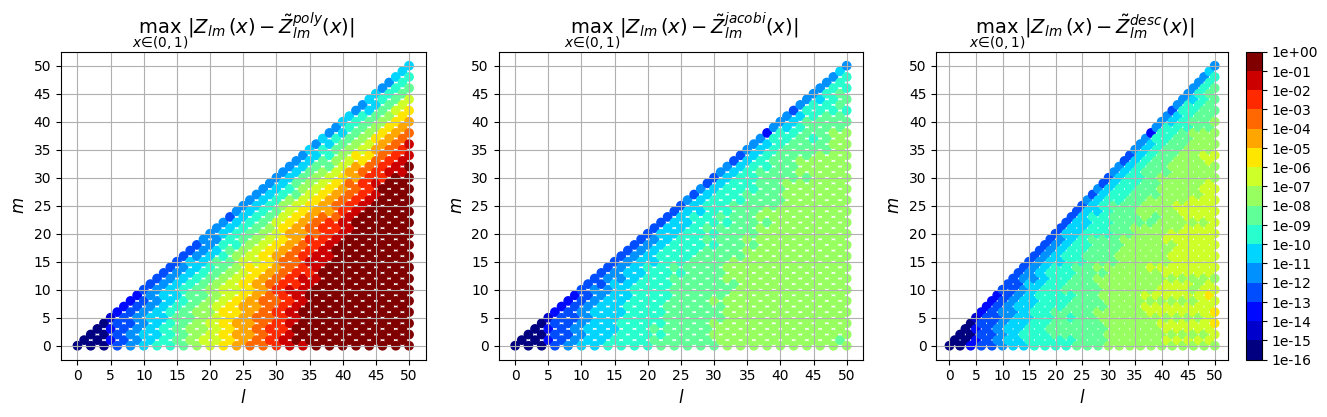

In [11]:
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(16, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp3 - zt3), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr3 - zt3), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zd3 - zt3), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, res+1, 5))
ax[0].set_yticks(np.arange(0, res+1, 5))
ax[1].set_xticks(np.arange(0, res+1, 5))
ax[1].set_yticks(np.arange(0, res+1, 5))
ax[2].set_xticks(np.arange(0, res+1, 5))
ax[2].set_yticks(np.arange(0, res+1, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$", fontsize=14
)
ax[2].set_title(
    "$\\max_{x \\in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{desc}(x)|$", fontsize=14
)

In [ ]:
import jax
def fun1(basis, r):
    jax.clear_caches();
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    return 0

def fun2(basis, r):
    jax.clear_caches();
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    return 0

def fun3(basis, r):
    jax.clear_caches();
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    return 0

def fun4(basis, r):
    jax.clear_caches();
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
    zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
    return 0

# %timeit -n 3 _ = fun1(basis, r)
# %timeit -n 3 _ = fun2(basis, r)

%timeit -n 3 _ = fun4(basis, r)
# %timeit -n 3 _ = fun3(basis, r)




In [ ]:
dr = 0
print(f"zernike_radial, derivative order: {dr}")

print("# With no duplicate modes (might have lacking modes)")
%timeit _ = zernike_radial_unique(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

# print("# With all the checks necessary but no reverse mode AutoDiff capable")
# %timeit _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

# print("# With all the checks necessary and reverse mode AutoDiff capable")
# %timeit _ = zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
# %timeit _ = zernike_radial_switch_gpu(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
# %timeit _ = zernike_radial_jvp(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
# %timeit _ = zernike_radial_jvp_gpu(r, basis.modes[:,0], basis.modes[:,1], dr, repeat=13).block_until_ready()

# print("# With all the checks necessary but less efficient")
# %timeit _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

In [ ]:
dr = 1
print(f"zernike_radial, derivative order: {dr}")

print("# With no duplicate modes (might have lacking modes)")
%timeit _ = zernike_radial_unique(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but no reverse mode AutoDiff capable")
%timeit _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary and reverse mode AutoDiff capable")
%timeit _ = zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_switch_gpu(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_jvp(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but less efficient")
%timeit _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

In [ ]:
dr = 2
print(f"zernike_radial, derivative order: {dr}")

print("# With no duplicate modes (might have lacking modes)")
%timeit _ = zernike_radial_unique(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but no reverse mode AutoDiff capable")
%timeit _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary and reverse mode AutoDiff capable")
%timeit _ = zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_switch_gpu(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_jvp(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but less efficient")
%timeit _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

In [ ]:
dr = 3
print(f"zernike_radial, derivative order: {dr}")

print("# With no duplicate modes (might have lacking modes)")
%timeit _ = zernike_radial_unique(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but no reverse mode AutoDiff capable")
%timeit _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary and reverse mode AutoDiff capable")
%timeit _ = zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_switch_gpu(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_jvp(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but less efficient")
%timeit _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

In [ ]:
dr = 4
print(f"zernike_radial, derivative order: {dr}")

print("# With no duplicate modes (might have lacking modes)")
%timeit _ = zernike_radial_unique(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but no reverse mode AutoDiff capable")
%timeit _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary and reverse mode AutoDiff capable")
%timeit _ = zernike_radial_switch(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_switch_gpu(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()
%timeit _ = zernike_radial_jvp(r, basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()

print("# With all the checks necessary but less efficient")
%timeit _ = zernike_radial_old_desc(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], dr).block_until_ready()